In [60]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [61]:
df_train = pd.read_csv("nndata/train.csv")
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df_train.isna().sum().sum()

0

El set no tiene datos faltantes.

In [63]:
df_train.mask(df_train.gt(255) & df_train.lt(0))
df_train.isna().sum().sum()

0

También se encontró que ningún pixel se sale del rango esperado

In [64]:
labels = df_train.pop('label')
features = np.array(df_train)
features_train, features_test, labels_train, labels_test = train_test_split(features, 
labels, test_size=0.33, random_state=42)

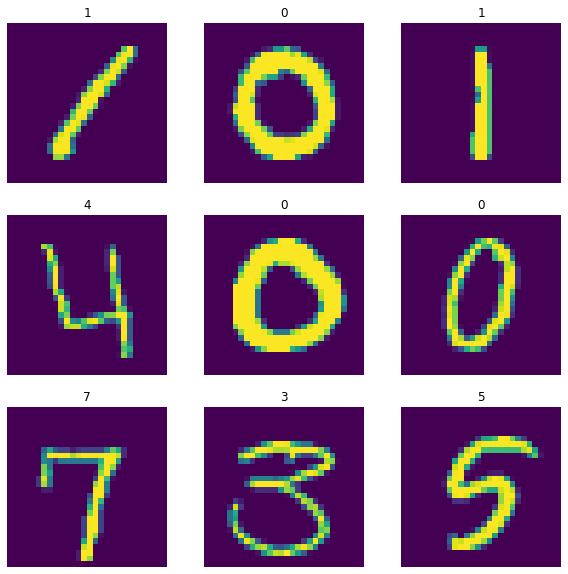

In [65]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = np.copy(features[i]).reshape((28,28))
    plt.imshow(img.astype('uint8'))
    plt.title(labels[i])
    plt.axis("off")

In [66]:
print(f'Min: {labels.min()}')
print(f'Max: {labels.max()}')

Min: 0
Max: 9


Al inspeccionar las gráficas y los máximos y mínimos de las labels se puede concluir que, de estar bien clasificados los números, estos van del 0 al 9.

In [173]:
keras.utils.set_random_seed(1234)
NN_simple = keras.Sequential()
NN_simple.bias = 0.5
NN_simple.add(keras.layers.Input(784))
NN_simple.add(keras.layers.Rescaling(1.0/255))

NN_simple.add(keras.layers.Dense(784, activation='relu'))
#NN_simple.add(keras.layers.Dense(392, activation='relu'))
NN_simple.add(keras.layers.Dense(196, activation='relu'))
#NN_simple.add(keras.layers.Dense(98,  activation='relu'))
NN_simple.add(keras.layers.Dense(49,  activation='relu'))

#NN_simple.add(keras.layers.Dropout(.2))


NN_simple.add(keras.layers.Dense(10, activation='softmax'))
NN_simple.output_shape



(None, 10)

In [172]:
#cambiar el formato de las labels para que la NN pueda mostrar las probabilidades de que el número sea tal en vez del valor del número
labels10 = np.zeros(shape=(labels_train.shape[0], 10), dtype=np.float32)
for i, val in enumerate(labels_train):
    labels10[i][val] = 1.0

In [69]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

In [174]:
NN_simple.compile( metrics=["accuracy"], 
optimizer = keras.optimizers.Adam(learning_rate=1e-3), 
loss="categorical_crossentropy")

In [175]:
NN_simple.fit(features_train, labels10, epochs=25, callbacks = callbacks)

Epoch 1/25
880/880 [==============================] - 9s 9ms/step - loss: 0.2565 - accuracy: 0.9226
Epoch 2/25
880/880 [==============================] - 8s 9ms/step - loss: 0.1100 - accuracy: 0.9668
Epoch 3/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0711 - accuracy: 0.9767
Epoch 4/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0540 - accuracy: 0.9825
Epoch 5/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0448 - accuracy: 0.9845
Epoch 6/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0368 - accuracy: 0.9883
Epoch 7/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0264 - accuracy: 0.9915
Epoch 8/25
880/880 [==============================] - 8s 10ms/step - loss: 0.0302 - accuracy: 0.9902
Epoch 9/25
880/880 [==============================] - 8s 10ms/step - loss: 0.0232 - accuracy: 0.9927
Epoch 10/25
880/880 [==============================] - 8s 9ms/step - loss: 0.0239 - accuracy: 0.99

In [176]:
prediction = NN_simple.predict(features_test)

434/434 [==============================] - 3s 6ms/step


In [177]:
prediction.shape

(13860, 10)

In [178]:
results = np.zeros(shape=prediction.shape[0], dtype='uint8')

for i in range(prediction.shape[0]):
    results[i] = int(np.argmax(prediction[i]))

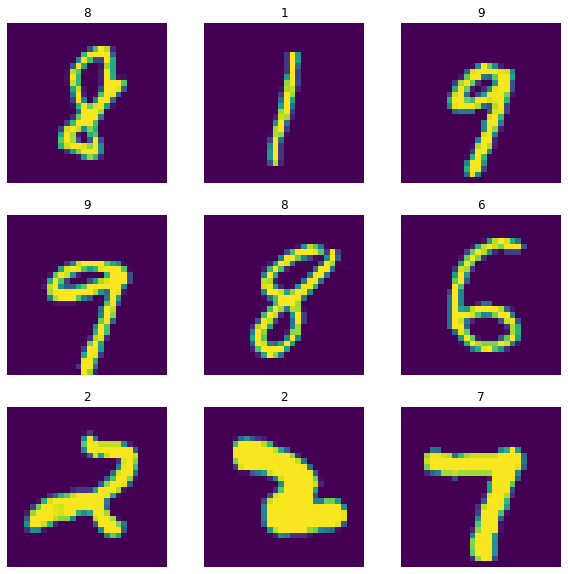

In [179]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = np.copy(features_test[i]).reshape((28,28))
    plt.imshow(img.astype('uint8'))
    plt.title(results[i])
    plt.axis("off")

In [188]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=labels_test, y_pred=results, labels=list(range(10)))

array([[1321,    0,    4,    0,    0,    1,    3,    1,    2,    1],
       [   1, 1506,    3,    0,    1,    0,    2,    3,    3,    1],
       [   4,    3, 1389,    1,    7,    0,    0,    2,    7,    1],
       [   2,    4,   13, 1432,    0,    3,    0,    4,   11,    2],
       [   4,    1,    1,    0, 1334,    0,    6,    2,    2,    8],
       [   4,    3,    0,   34,    0, 1136,   17,    1,    5,    5],
       [   5,    2,    0,    0,    2,    2, 1382,    0,    4,    0],
       [   1,    8,   24,    2,   10,    0,    0, 1432,    0,    3],
       [   0,   10,   13,   12,    5,    3,    8,    1, 1280,    2],
       [   5,    6,    6,    4,   36,    0,    0,    7,   11, 1273]],
      dtype=int64)